# Algorytm k średnich (centroidów) - część I

4 grudzień 2017

#### Wstęp

Metoda k średnich jest metodą uczenia maszynowego bez nauczyciela. W praktyce oznacza to, że nie posiadamy oznaczeń grupy, danej Y przyporządkowującej dane wejściowe do danej grupy. Skutkiem tego nie możemy zastosować żadnej metody klasyfikacyjnej. Pozostają nam metody klastrowania czyli takie które w danych wyjściowych odszukują reguł łączących dane w "paczki", skupiska danych połączone pewnymi wspólnymi cechami.

Metoda k średnich wywodzi swą nazwę od sposobu działania. A mianowice wyznacza ona pewną ilość średnich z argumentów wejściowych i przyporządkowuje dane wejściowe do każdej z nich czyli grupuje wokół pewnych centralnych punktów (centroid). Ich liczna może być dowolna i jest ostatecznie definiowana przez twórcę modelu dlatego ważne jest to aby analizowane dane rozumieć i umieć logicznie uzasadnić wybraną przez nas liczbę klastrów. 


Prezentowany materiał zakłada znajomość podstaw pythona i statystyki.


#### Narzędzia

Do budowy modelu, analizy i prezentacji wyników użyty zostanie pakiet narzędzi scikit-learn, numpy, pandas oraz matplotlib.

*Importujemy wszystkie potrzebne biblioteki*

In [1]:
import numpy as np
import pandas as pd
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist,pdist
from sklearn import datasets
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.metrics.pairwise import pairwise_distances_argmin

import seaborn as sns

*Dane wejściowe pochodzą ze zbioru danych UCI (https://archive.ics.uci.edu/ml/datasets/DrivFace) i zawierają sekwencję obrazów 4 kierowców (zmienna subject) w realnych sytuacjach drogowych z klasyfikacją kierunku w jakim kierowca spogląda (lewo/na wprost/prawo) (zmienna label)*

In [2]:
# Load CSV and columns
df = pd.read_csv("./data/drivPoints.txt")

df.head(n=5)

,fileName,subject,imgNum,label,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
0,20130529_01_Driv_001_f,1,1,2,0,292,209,100,112,323,232,367,231,353,254,332,278,361,278
1,20130529_01_Driv_002_f,1,2,2,0,286,200,109,128,324,235,366,235,353,258,333,281,361,281
2,20130529_01_Driv_003_f,1,3,2,0,290,204,105,121,325,240,367,239,351,260,334,282,362,282
3,20130529_01_Driv_004_f,1,4,2,0,287,202,112,118,325,230,369,230,353,253,335,274,362,275
4,20130529_01_Driv_005_f,1,5,2,0,290,193,104,119,325,224,366,225,353,244,333,268,363,268


*Przed przystąpieniem do wyznaczania klastrów należy się zastanowić nad tym czym poszczególne dane będą się różnić. Jeżeli od razu będziemy oczekiwać, że uda się pogrupować dane według tego w którą stronę kierowca patrzy, nie uda nam się tego przeprowadzić. Powód jest następujący - różnica w wyglądzie poszczególnych kierowców jest tak duża, że program pogrupuje nam dane nie według tego w która stronę kierowca patrzy ale według kierowców. A więc spróbumy iść w tą stronę i pozwólmny pogrupować dane wg. kierowcy czyli danej subject*

In [3]:
df.groupby('subject').describe()

ang                                                         hF  \
         count      mean        std   min    25%   50%   75%   max  count   
subject                                                                     
1        179.0  2.513966  14.264499 -45.0   0.00   0.0   0.0  45.0  179.0   
2        170.0  5.823529  16.656059 -45.0   0.00  15.0  15.0  45.0  170.0   
3        167.0  9.161677   9.144962 -30.0   0.00  15.0  15.0  15.0  167.0   
4         90.0  4.333333  16.096618 -30.0 -11.25   0.0  15.0  45.0   90.0   

                     ...      yRE           yRM                               \
               mean  ...      75%    max  count        mean       std    min   
subject              ...                                                       
1        118.318436  ...    243.5  270.0  179.0  283.988827  9.221366  267.0   
2        130.900000  ...    201.0  214.0  170.0  240.400000  9.448960  221.0   
3        130.700599  ...    292.0  302.0  167.0  339.119760  7.344207  324.0   
4        135.344444  ...    211.0  222.0   90.0  259.844444  6.974933  243.0   

                                      
            25%    50%    75%    max  
subject                               
1        277.00  283.0  289.0  314.0  
2        232.25  240.0  249.0  262.0  
3        334.00  338.0  346.0  355.0  
4        256.00  260.5  264.0  275.0  

[4 rows x 136 columns]

*Wybieramy dane na podstawie których algorytm będzie tworzył grupy*

In [4]:
X = df[['ang','xF','yF','wF','hF','xRE','yRE','xLE','yLE','xN','yN','xRM','yRM','xLM','yLM']]
labels = df['subject']
X = X.astype(float)
X.head()

,ang,xF,yF,wF,hF,xRE,yRE,xLE,yLE,xN,yN,xRM,yRM,xLM,yLM
0,0.0,292.0,209.0,100.0,112.0,323.0,232.0,367.0,231.0,353.0,254.0,332.0,278.0,361.0,278.0
1,0.0,286.0,200.0,109.0,128.0,324.0,235.0,366.0,235.0,353.0,258.0,333.0,281.0,361.0,281.0
2,0.0,290.0,204.0,105.0,121.0,325.0,240.0,367.0,239.0,351.0,260.0,334.0,282.0,362.0,282.0
3,0.0,287.0,202.0,112.0,118.0,325.0,230.0,369.0,230.0,353.0,253.0,335.0,274.0,362.0,275.0
4,0.0,290.0,193.0,104.0,119.0,325.0,224.0,366.0,225.0,353.0,244.0,333.0,268.0,363.0,268.0


*Pierwszym krokiem jest właściwy wybór liczby grup. Jest to decyzja którą musi podjąć twórca modelu. Wyliczamy średnią odległość od punktów centralnych kolejno dla liczby centroid k od 1 do 9*

In [5]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist


K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

*Rysujemy wykres pozwalający ocenić właściwą liczbę k. Stosuje się tutaj zasadę, że punkt przegięcia krzywej jest tą włąściwą liczbą. Oczywiście jest to ocena subiektywna i jak widzimy równie dobrą wartością jest liczba 3 ale ponieważ z góry wiemy jaka była liczba osób możemy przyjąć od razu liczbę 4 choć jak zobaczymy na następnym wykresie podział na 3 grupy jest bardziej intuicyjny*

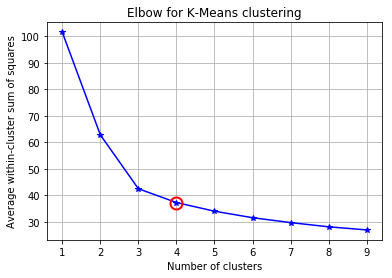

In [6]:
kIdx = 3
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')

plt.show()

*W celu wizualizacji redukujemy liczbę wymiarów do 2. Widzimy, że po redukcji nie tracimy zbyt dużo informacji*

In [7]:
pca = PCA(n_components=2, svd_solver='randomized').fit(X)
X_2d = pca.transform(X)

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 97%


*Wykres pozwala nam na wizualizację grup danych wejściowych. Wykres prezentuje wygląd realnych grup*

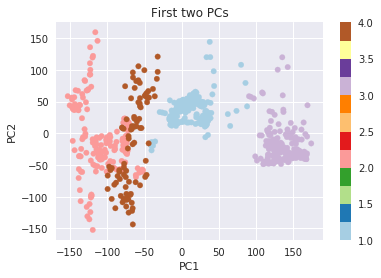

In [8]:
sns.set()

plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=30, cmap=plt.cm.Paired)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs')

plt.show()

*Teraz do utworzenia modelu użyjemy algorytmu Mini Batch K-Means. Jest to wariany algorytmu K-Means ale skracający czas wykonania poprzez podział danych wejściowych na podgrupy i wykonujący je w sposób równoległy*

In [9]:
mbk = MiniBatchKMeans(n_clusters=4, init='k-means++', n_init=1,
                     init_size=1000, batch_size=1000, verbose=False)

labels_pred = mbk.fit_predict(X_2d)

*Wykres wygląda bardzo podobnie co poprzedni. Jedna podział pomiedzy grupami z lewej strony jest troszku inny. Ale problem podziału tych grup był już widoczny przy analizie krzywej łokciowej*

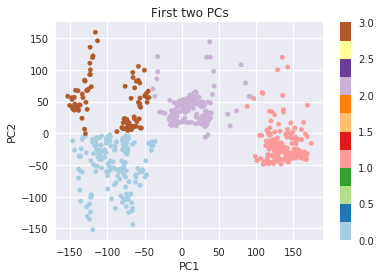

In [10]:
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_pred, s=20, cmap=plt.cm.Paired)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs')

plt.show()

*Na koniec zwizualizujemy położenie centroid aby lepiej uzmysłowić sobie działanie algorytmu*

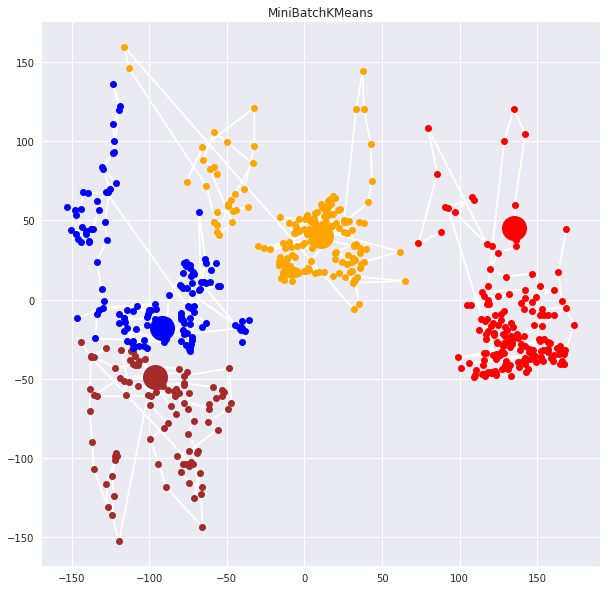

In [11]:
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
mbk_means_labels = pairwise_distances_argmin(X_2d, mbk_means_cluster_centers)

colors = ['brown', 'blue', 'orange', 'red']
n_clusters = 4

plt.figure(figsize=(10,10))

for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    plt.plot(X_2d[my_members, 0], X_2d[my_members, 1], 'w', markerfacecolor=col, marker='o')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=25)
plt.title('MiniBatchKMeans')
plt.show()

*Na końcu rzut okiem na parametry jakości podziału na grupy. Parametry jednorodność (homogeneity) i kompletność (completeness) mówia nam:*

*jednorodność - każdy klaster zawiera tylko punkty należące do tej samej klasy*

*kompletność - wszystkie punkty należące do tej samej klasy są przydzielone do tego samego klastra*

*Im są one wyższe tym podział na klastry jest lepszy*

In [12]:
from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, mbk.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, mbk.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, mbk.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, mbk.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_2d, mbk.labels_, sample_size=1000))

print()

Homogeneity: 0.718
Completeness: 0.718
V-measure: 0.718
Adjusted Rand-Index: 0.713
Silhouette Coefficient: 0.560

